
# Cloud Detection with Bancroft Model
### Flying Ramen Pokémon
Chenyang Zhu and Ling Xie, UC Berkeley

# Section 1.  Data Collection and Exploration

## 1. Import packages and read data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle
import sklearn.linear_model
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.svm
import sklearn.model_selection

read in raw data provided in Shi et al. [2018]

In [0]:
img1 = pd.read_csv("./img1.csv", index_col=0)
img2 = pd.read_csv("./img2.csv", index_col=0)
img3 = pd.read_csv("./img3.csv", index_col=0)

Change column name for later user

In [0]:
col_names = ['x', 'y', 'label', 'NDAI', 'SD', 'CORR','DF','CF','BF','AF','AN']
img1.columns = col_names
img2.columns = col_names
img3.columns = col_names

Delete 0 point for unlabeled data. We are not going to use these data.

In [0]:
img1 = img1[img1['label'] != 0.0]
img1_n = int(len(img1) * 0.8)
img2 = img2[img2['label'] != 0.0]
img2_n = int(len(img2) * 0.8)
img3 = img3[img3['label'] != 0.0]
img3_n = int(len(img3) * 0.8)

Concatenate into a large dataset.

In [0]:
data =  pd.concat([img1, img2])
data = pd.concat([data, img3])

## 2. Data Exploration

The padded images are located in `./data/pads`

(-0.5, 383.5, 383.5, -0.5)

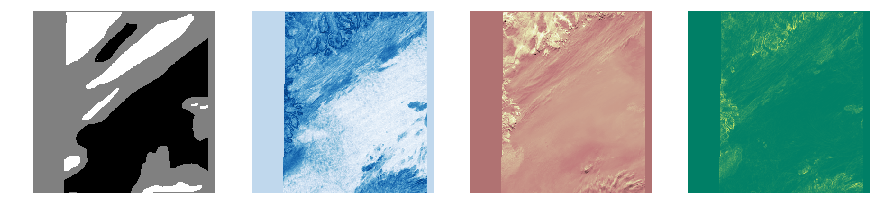

In [0]:
plt.figure(figsize=(15,60))

plt.subplot(1,4,1)
plt.imshow(img1_pad, cmap = "gist_gray")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img1_pad_ndai, cmap="Blues")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img1_pad_corr,cmap='pink')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(img1_pad_sd, cmap = "summer")
plt.axis('off')

# White is cloud

(-0.5, 383.5, 383.5, -0.5)

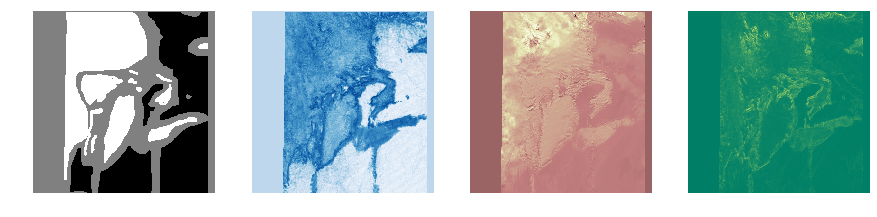

In [0]:
plt.figure(figsize=(15,60))

plt.subplot(1,4,1)
plt.imshow(img2_pad, cmap = "gist_gray")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img2_pad_ndai, cmap="Blues")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img2_pad_corr,cmap='pink')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(img2_pad_sd, cmap = "summer")
plt.axis('off')


(-0.5, 383.5, 383.5, -0.5)

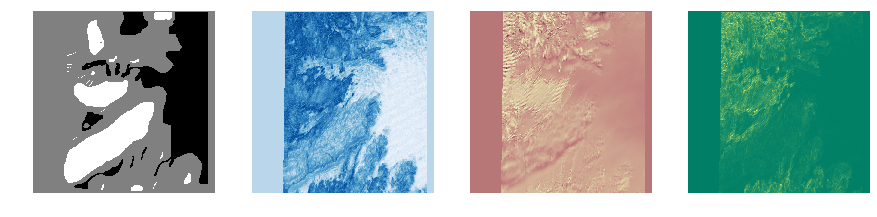

In [0]:
plt.figure(figsize=(15,60))

plt.subplot(1,4,1)
plt.imshow(img3_pad, cmap = "gist_gray")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img3_pad_ndai, cmap="Blues")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img3_pad_corr,cmap='pink')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(img3_pad_sd, cmap = "summer")
plt.axis('off')

## 3. Visual and Qualitative EDA

Text(0.5, 1.0, 'Pairwise correlation between features')

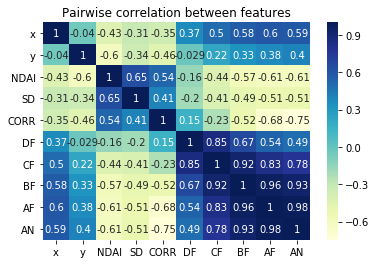

In [0]:
sns.heatmap(data.loc[:, data.columns != 'label'].corr(), \
            cmap="YlGnBu", annot=True).set_title('Pairwise correlation between features')

Text(0.5, 1.0, 'Correlation Heatmap between Lables and Features')

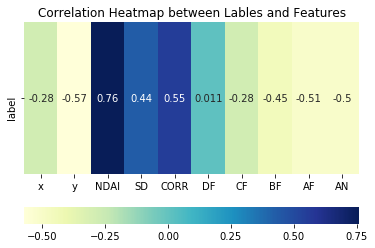

In [0]:
sns.heatmap(data.corr().iloc[2:3, [0,1,3,4,5,6,7,8,9,10]], \
            cmap="YlGnBu", annot=True,cbar_kws={"orientation": "horizontal"}).\
set_title('Correlation Heatmap between Lables and Features')

Text(0.5, 1.0, 'Boxplot of NDAI with respect to cloudiness')

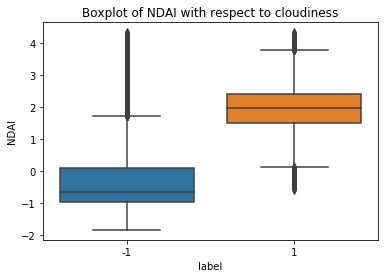

In [0]:
sns.boxplot(x="label", y="NDAI", data=data).\
set_title('Boxplot of NDAI with respect to cloudiness')

Text(0.5, 1.0, 'Boxplot of AF with respect to cloudiness')

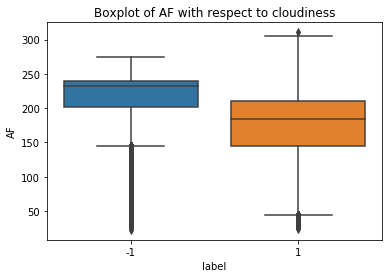

In [0]:
sns.boxplot(x="label", y="AF", data=data).\
set_title('Boxplot of AF with respect to cloudiness')

The boxplot shown above illustrates the difference in the distribution of NDAI with respect to cloudiness. For pixels labelled as cloudiness, they generally have higher NDAIs compared to those labelled as cloud-free and a larger range of possible values of NDAIs.


# Section 2. Preparation

## 1. Split Data

We consider two data split methods.

### Split Method #1

The first method is to do proportional sampling on each image has the same representationin each set.  To do this, we randomly shuffle the pixels in each image and split each image into threesets, each for train, valid and test.  Finally we combine the three images together.

In [0]:
def split1(img):
  # For 1
  subset = img[img['label'] == 1]
  subset = subset.sample(frac=1)
  len_subset = len(subset)
  
  train = subset.iloc[:int(len_subset*0.6)]
  val = subset.iloc[int(len_subset*0.6):int(len_subset*0.8)]
  test = subset.iloc[int(len_subset*0.8):]
  
  # For -1
  subset = img[img['label'] == -1]
  subset = subset.sample(frac=1)
  len_subset = len(subset)
  
  train = pd.concat([train,subset.iloc[:int(len_subset*0.6)]])
  val = pd.concat([val,subset.iloc[int(len_subset*0.6):int(len_subset*0.8)]])
  test = pd.concat([test,subset.iloc[int(len_subset*0.8):]])
  
  return train, val, test

img1_train, img1_val, img1_test = split1(img1)
img2_train, img2_val, img2_test = split1(img2)
img3_train, img3_val, img3_test = split1(img3)

train_1 = pd.concat([img1_train,img2_train,img3_train])
val_1 = pd.concat([img1_val,img2_val,img3_val])
test_1 = pd.concat([img1_test,img2_test,img3_test])

train_1 = train_1.sample(frac=1)
test_1 = test_1.sample(frac=1)
val_1 = val_1.sample(frac=1)

In [0]:
train_feat_1 = train_1.loc[:, train_1.columns != 'label']
train_label_1 = train_1['label']

val_feat_1 = val_1.loc[:, val_1.columns != 'label']
val_label_1 = val_1['label']

# train_feat_1 = pd.concat([train_feat_1, val_feat_1])
# train_label_1 = pd.concat([train_label_1, val_label_1])

test_feat_1 = test_1.loc[:, test_1.columns != 'label']
test_label_1 = test_1['label']

### Split Method #2

Considering the spatial dependence of the image pixels, we decided not to do random shuffling. Instead, in order the preserve the spatial pattern, we split the data based on the sequential order: first 60% of the data (rows in the dataset) in each image constitutes the training set, the following 20% goes to validation set and the last 20% will be used for testing.

In [0]:
train_2 = img1.iloc[:int(img1.shape[0] * 0.6),:]
train_2 = pd.concat([train_2, img2.iloc[:int(img2.shape[0] * 0.6),:]])
train_2 = pd.concat([train_2, img3.iloc[:int(img3.shape[0] * 0.6),:]])
train_2.index = range(len(train_2))

valid_2 = img1.iloc[int(img1.shape[0] * 0.6):int(img1.shape[0] * 0.8),:]
valid_2 = pd.concat([valid_2, img2.iloc[int(img2.shape[0] * 0.6):int(img2.shape[0] * 0.8),:]])
valid_2 = pd.concat([valid_2, img3.iloc[int(img3.shape[0] * 0.6):int(img3.shape[0] * 0.8),:]])
valid_2.index = range(len(valid_2))

train_valid_2 = pd.concat([train_2, valid_2])
train_valid_2.index = range(len(train_valid_2))

test_2 = img1.iloc[int(img1.shape[0] * 0.8):,:]
test_2 = pd.concat([test_2, img2.iloc[int(img2.shape[0] * 0.8):,:]])
test_2 = pd.concat([test_2, img3.iloc[int(img3.shape[0] * 0.8):,:]])
test_2.index = range(len(test_2))

In [0]:
train_feat_2 = train_2.loc[:, train_2.columns != 'label']
train_label_2 = train_2['label']

valid_feat_2 = valid_2.loc[:, valid_2.columns != 'label']
valid_label_2 = valid_2['label']

test_feat_2 = test_2.loc[:, test_2.columns != 'label']
test_label_2 = test_2['label']

## 2. Baseline Accuracy

In [0]:
def baseline_classifier(test_feat):
  return np.repeat(-1, len(test_feat))

baseline_accuracy = np.sum(baseline_classifier(test_feat_2) == test_label_2) + \
np.sum(baseline_classifier(valid_feat_2) == valid_label_2)

baseline_accuracy =  baseline_accuracy / (len(test_feat_2) + len(valid_feat_2))
print('The baseline accuracy is ' + str(round(baseline_accuracy,3)))

The baseline accuracy is 0.898


For Split 1

In [0]:
baseline_train_1 = np.mean(train_label_1 == -1)
baseline_test_1 = np.mean(test_label_1 == -1)
baseline_val_1 = np.mean(val_label_1 == -1)
print((baseline_train_1, baseline_val_1, baseline_test_1))

(0.6107871253024015, 0.6107759967316334, 0.6107747020376778)


For Split 2

In [0]:
baseline_train_2 = np.mean(train_label_2 == -1)
baseline_test_2 = np.mean(test_label_2 == -1)
baseline_valid_2 = np.mean(valid_label_2 == -1)
print((baseline_train_2, baseline_valid_2, baseline_test_2))

(0.4195858533263908, 0.8520859367490147, 0.9430480126880377)


## 4. CV Generic

In [0]:
import time
def CVGeneric(classifier, img_train, K, loss_func, cvsplit_method, \
              img1_n =  img1_n, img2_n = img2_n, img3_n = img3, **kwargs):
  # Input:
    # Classifier:     function    some classifier
    # img:            dataframe   training X matrix  and labels
    # K:              int         K-fold CV
    # loss_func:      function    some loss function
  # Output:
    # K-fold CV loss  float       loss

  cv_label = cvsplit_method(img_train, K, img1_n, img2_n, img3_n)
  # print(cv_label)
  val_acc = []
  loss = []
  
  # Change img_train indexing for logistic models
  img = img_train.copy()
  img['label'] = np.where(img['label'] == -1.0, 0.0,1.0)
  start = time.time()
  for k in range(K):
    # CV Training data
    img_cvval = img.loc[cv_label[k]]
    img_cvtrain = img.drop(cv_label[k])

    # Use the remaining cv_label to test
    # print(img_cvval['label'])
    # print(img_cvtrain['label'])
    predictions = classifier(img_cvtrain, img_cvval, **kwargs)
    
#     print(predictions)
#     print(img_cvval['label'])

    val_acc.append(np.mean(predictions == img_cvval['label']))
    # val_acc[k] <- sum(abs(predictions - img.cvval$label)) / nrow(img.cvval)
    loss.append(loss_func(predictions, img_cvval['label']))
  print("--- %s seconds ---" % (time.time() - start))
  outcome = {}
  outcome['val_acc'] = val_acc
  outcome['loss'] = loss
  
  return outcome

### Loss Function

In [0]:
def default_loss(y_hat,y):
#   print(y)
#   print(y_hat)
  return sklearn.metrics.log_loss(y, y_hat)
#   return np.sum(np.abs(y_hat-y))/len(y)

### Classifiers

In [0]:
FEATURE = ['CORR','NDAI','SD', 'DF','CF','BF','AF','AN']

In [0]:
def logistic(train, val, **kwargs):
  '''
  Need to input threshod
  '''
  threshold = kwargs["threshold"]
  model = sklearn.linear_model.LogisticRegression()
  model.fit(train[FEATURE], train['label'])
  prediction = model.predict(val[FEATURE])
  prediction = np.where(prediction > threshold, 1, 0)
  return prediction

In [0]:
def LDA(train, val):
  '''
  https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
  '''
  model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
  model.fit(train[FEATURE], train['label'])
  prediction = model.predict(val[FEATURE])
  return prediction

In [0]:
def QDA(train, val):
  '''
  https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
  '''
  model = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
  model.fit(train[FEATURE], train['label'])
  prediction = model.predict(val[FEATURE])
  return prediction

In [0]:
def randomforest(train, val, **kwargs):
  '''
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  need to inpu n_estimators=100, max_depth=2 in CVgeneric
  '''
  n_estimators = kwargs['n_estimators']
  max_depth = kwargs['max_depth']
  
  model = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                                  max_depth=max_depth,
                                                  random_state=0)
  model.fit(train[FEATURE], train['label'])
  prediction = model.predict(val[FEATURE])
  return prediction

In [0]:
def SVM(train, val,**kwargs):
  '''
  Need to input kernel='rbf' in CVgeneric
  '''
  kernel = kwargs['kernel']
  model = sklearn.svm.SVC(kernel = kernel)
  model.fit(train[FEATURE], train['label'])
  prediction = model.predict(val[FEATURE])
  return prediction

### Split Method

In [0]:
def cv_split_1(img, K, img1_n, img2_n, img3_n):
  
  img_cvlist = [[] for _ in range(K)]
  
  for i in [-1,1]:
    img_specific = img[img['label'] == i]
    idx = list(img_specific.index)
    shuffle(idx)
    
    chunk_size = int(len(idx) / K)

    for k in range(K):
      
      start = chunk_size * k      
      end = chunk_size * (k+1)-1
      img_k = idx[start:end]
      img_cvlist[k].extend(img_k)
        
  return img_cvlist

In [0]:
def cv_split_2(train, k, img1_n, img2_n, img3_n):
  
  indices = [[] for _ in range(k)]
  img1_sub_size = int(img1_n / k)
  img2_sub_size = int(img2_n / k)
  img3_sub_size = int(img3_n / k)
  
#   img1_endpoint = 0
#   img2_endpoint = img1_n
#   img3_endpoint = img1_n + img2_n
  img1_start, img2_start, img3_start = 0, 0, 0
  
  for i in range(1, k+1):
    if i != k:
      indices[i-1].extend(range(img1_start, img1_start + img1_sub_size))
      indices[i-1].extend(range(img2_start, img2_start + img2_sub_size))
      indices[i-1].extend(range(img3_start, img3_start + img3_sub_size))
    else:
      indices[i-1].extend(range(img1_start, img1_n))
      indices[i-1].extend(range(img2_start, img2_n))
      indices[i-1].extend(range(img3_start, img3_n))
      
    img1_start += img1_sub_size
    img2_start += img2_sub_size
    img3_start += img3_sub_size
  
  return indices

# Section 3.  Modeling

## 1. Modeling and Accuracy

In [0]:
log_1 = CVGeneric(logistic, pd.concat([train_1,val_1]), 10, default_loss, \
                  cv_split_1,threshold = 0.3)

rf_1 = CVGeneric(randomforest, pd.concat([train_1,val_1]), 10, default_loss,\
                 cv_split_1,n_estimators=100, max_depth=20, max_features = 8)

LDA_1 = CVGeneric(LDA, pd.concat([train_1,val_1]), 10, default_loss, cv_split_1)

QDA_1 = CVGeneric(QDA, pd.concat([train_1,val_1]), 10, default_loss, cv_split_1)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

--- 14.432773113250732 seconds ---
--- 389.3849048614502 seconds ---
--- 3.681649684906006 seconds ---
--- 2.8349006175994873 seconds ---


In [0]:
log_2 = CVGeneric(logistic, train_valid_2, 10, default_loss, cv_split_2, \
                  img1_n, img2_n, img3_n, threshold = 0.3)
rf_2 = CVGeneric(randomforest, train_valid_2, 10, default_loss, cv_split_2, \
                 img1_n, img2_n, img3_n, n_estimators=100, max_depth=20, \
                 max_features = 8)
LDA_2 = CVGeneric(LDA, train_valid_2, 10, default_loss, cv_split_2, \
                  img1_n, img2_n, img3_n)
QDA_2 = CVGeneric(QDA, train_valid_2, 10, default_loss, cv_split_2, \
                  img1_n, img2_n, img3_n)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

--- 16.5924870967865 seconds ---
--- 403.4120411872864 seconds ---
--- 2.4166972637176514 seconds ---
--- 1.0970849990844727 seconds ---


In [0]:
print(log_1)
print(rf_1)
print(LDA_1)
print(QDA_1)

{'val_acc': [0.8862736674133858, 0.8842494876265639, 0.8819535765619744, 0.8876883882255441, 0.8852156814550817, 0.8824536725582534, 0.8854454897620365, 0.8884910798984057, 0.8875876060494282, 0.8825266914864158], 'loss': [3.9280121214520225, 3.9979249932803116, 4.077223283761089, 3.8791503390496516, 3.9645553357206205, 4.0599505270072305, 3.956618265383542, 3.851426311954609, 3.8826294040977083, 4.057429701653188]}
{'val_acc': [0.9570454126467154, 0.9588431931793786, 0.9602152839362711, 0.9595738785061116, 0.9604589097825087, 0.9584742115940247, 0.9597247396393352, 0.9573084708335889, 0.958843329253366, 0.9602711698781567], 'loss': [1.4836223258167998, 1.4215285781328448, 1.37413675845801, 1.3962902877142689, 1.3657229488857656, 1.43427309675727, 1.3910806637516244, 1.4745361824236403, 1.4215237783710999, 1.3722072289448892]}
{'val_acc': [0.8899539170506913, 0.8906615025205951, 0.8904407485681032, 0.8898367272060173, 0.8900281586679726, 0.8891480481217776, 0.887399876771411, 0.8878951

In [0]:
print(np.mean(log_1['val_acc']))
print(np.mean(rf_1['val_acc']))
print(np.mean(LDA_1['val_acc']))
print(np.mean(QDA_1['val_acc']))

0.8703344145591035
0.953398091661995
0.872242020877368
0.8732456040228895


In [0]:
print(log_2)
print(rf_2)
print(LDA_2)
print(QDA_2)

{'val_acc': [0.9098419756053596, 0.9153397824911375, 0.8602715856516253, 0.8372288649882834, 0.8543231388571771, 0.8899537343027099, 0.9193453513719249, 0.9343590637667263, 0.9568006843455945, 0.9482361757935871], 'loss': [3.1139535139734575, 2.9240966674208444, 4.826132584357691, 5.622020475696449, 5.031590687618741, 3.8009313703924392, 2.785756560011041, 2.2671970707852718, 1.4920770018462832, 1.7878785820412162]}
{'val_acc': [0.9413266838911254, 0.9503695247251096, 0.9169921288229286, 0.8883013879709187, 0.893108213663402, 0.9318332031484708, 0.9497595238919069, 0.9522294381728632, 0.9729113202167095, 0.9614581660510679], 'loss': [2.0265078364510165, 1.7142035612759736, 2.8670414685352563, 3.8580109035986654, 3.691985782862056, 2.35444094562975, 1.7352743120531398, 1.6499645995366279, 0.9356270678992008, 1.331204862893333]}
{'val_acc': [0.9245027939674337, 0.922009253139458, 0.8602715856516253, 0.8311001622303671, 0.8550441627110497, 0.8926876164153097, 0.9224940313483962, 0.9356230

In [0]:
print(np.mean(log_2['val_acc']))
print(np.mean(rf_2['val_acc']))
print(np.mean(LDA_2['val_acc']))
print(np.mean(QDA_2['val_acc']))

0.9025700357174126
0.9358289590554504
0.9055340168968783
0.8872211550625122


In [0]:
test_all = pd.concat([test_1, test_2])
test_all.drop_duplicates(subset = ['x', 'y', 'SD', 'NDAI','AF'], 
                     keep = 'first', inplace = True)
test_all_labels = test_all['label']
test_all_feat = test_all[FEATURE]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
val_all = pd.concat([val_1, valid_2])
val_all.drop_duplicates(subset = ['x', 'y', 'SD', 'NDAI','AF'], 
                     keep = 'first', inplace = True)
val_all_labels = val_all['label']
val_all_feat = val_all[FEATURE]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
y_true = np.where(test_all_labels == -1.0, 0.0,1.0)
logistic_model_1 = sklearn.linear_model.LogisticRegression()
logistic_model_1.fit(train_1[FEATURE], train_1['label'])
logistic_pred_1 = logistic_model_1.predict(test_all[FEATURE])
logistic_pred_1 = np.where(logistic_pred_1 > 0.3, 1, 0)
log_acc_1 = np.mean(logistic_pred_1 == y_true)

logistic_model_2 = sklearn.linear_model.LogisticRegression()
logistic_model_2.fit(train_2[FEATURE], train_2['label'])
logistic_pred_2 = logistic_model_2.predict(test_all[FEATURE])
logistic_pred_2 = np.where(logistic_pred_2 > 0.3, 1, 0)
log_acc_2 = np.mean(logistic_pred_2 == y_true)

print('Logistic Model for splitting method 1: ')
print(log_acc_1)

print('Logistic Model for splitting method 2: ')
print(log_acc_2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Model for splitting method 1: 
0.9167712980525206
Logistic Model for splitting method 2: 
0.9143002163866107


In [0]:
rf_model_1 = sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                                                  max_depth=20,
                                                  random_state=0)
rf_model_1.fit(train_1[FEATURE], train_1['label'])
rf_pred_1 = rf_model_1.predict(test_all[FEATURE])
rf_acc_1 = np.mean(rf_pred_1 == test_all_labels)

rf_model_2 = sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                                                  max_depth=20,
                                                  random_state=0)
rf_model_2.fit(train_2[FEATURE], train_2['label'])
rf_pred_2 = rf_model_2.predict(test_all[FEATURE])
rf_acc_2 = np.mean(rf_pred_2 == test_all_labels)

print('Random Forest for splitting method 1: ')
print(rf_acc_1)

print('Random Forset for splitting method 2: ')
print(rf_acc_2)

Random Forest for splitting method 1: 
0.9755028985120081
Random Forset for splitting method 2: 
0.9370074533165923


In [0]:
lda_model_1 = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda_model_1.fit(train_1[FEATURE], train_1['label'])
lda_pred_1 = lda_model_1.predict(test_all[FEATURE])
lda_acc_1 = np.mean(lda_pred_1 == test_all_labels)

lda_model_2 = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda_model_2.fit(train_2[FEATURE], train_2['label'])
lda_pred_2 = lda_model_2.predict(test_all[FEATURE])
lda_acc_2 = np.mean(lda_pred_2 == test_all_labels)

print('LDA for splitting method 1: ')
print(lda_acc_1)

print('LDA for splitting method 2: ')
print(lda_acc_2)

LDA for splitting method 1: 
0.9192423797184303
LDA for splitting method 2: 
0.9173189431784788


In [0]:
qda_model_1 = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model_1.fit(train_1[FEATURE], train_1['label'])
qda_pred_1 = qda_model_1.predict(test_all[FEATURE])
qda_acc_1 = np.mean(qda_pred_1 == test_all_labels)

qda_model_2 = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model_2.fit(train_2[FEATURE], train_2['label'])
qda_pred_2 = qda_model_2.predict(test_all[FEATURE])
qda_acc_2 = np.mean(qda_pred_2 == test_all_labels)

print('QDA for splitting method 1: ')
print(qda_acc_1)

print('QDA for splitting method 2: ')
print(qda_acc_2)

QDA for splitting method 1: 
0.9212459594475463
QDA for splitting method 2: 
0.9183474474394251


## 2. ROC Curve

###  Use split 1

In [0]:
import sklearn.metrics

In [0]:
FEATURE = ['NDAI',
 'SD',
 'CORR',
 'DF',
 'CF',
 'BF',
 'AF',
 'AN']

fpr_list = []
tpr_list = []
threshold_list = []
auc_list = []


#LDA
print("LDA")
model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
model.fit(train_1[FEATURE], train_1['label'])
score = model.predict_proba(test_1[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_1['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_1['label'], score[:,1])
fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)


# LR
print("LR")
model = sklearn.linear_model.LogisticRegression()
model.fit(train_1[FEATURE], train_1['label'])
score = model.predict_proba(test_1[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_1['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_1['label'], score[:,1])

fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)


# QDA
print("QDA")
model = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
model.fit(train_1[FEATURE], train_1['label'])
score = model.predict_proba(test_1[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_1['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_1['label'], score[:,1])

fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)


# SVM
# print("SVM")
# model = sklearn.svm.SVC(kernel = 'rbf',probability=True)
# model.fit(train_1[FEATURE], train_1['label'])
# score = model.predict_proba(test_1[FEATURE])
# fpr, tpr, threshold = sklearn.metrics.roc_curve(test_1['label'], score[:,1])
# auc = sklearn.metrics.roc_auc_score(test_1['label'], score[:,1])
# fpr_list.append(fpr)
# tpr_list.append(tpr)
# threshold_list.append(threshold)
# auc_list.append(auc)


print("RF")
# RF
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                                                  max_depth=20,
                                                  random_state=0)
model.fit(train_1[FEATURE], train_1['label'])
score = model.predict_proba(test_1[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_1['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_1['label'], score[:,1])

fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)

LDA
LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


QDA
RF


In [0]:
optimal_threshold_list = []

for i in range(4):
  optimal_idx = np.argmax(tpr_list[i] - fpr_list[i])
  optimal_threshold = threshold_list[i][optimal_idx]
  optimal_threshold_list.append(optimal_threshold)

In [0]:
optimal_idx_list = []

for i in range(4):
  optimal_idx = np.argmax(tpr_list[i] - fpr_list[i])
  optimal_idx_list.append(optimal_idx)

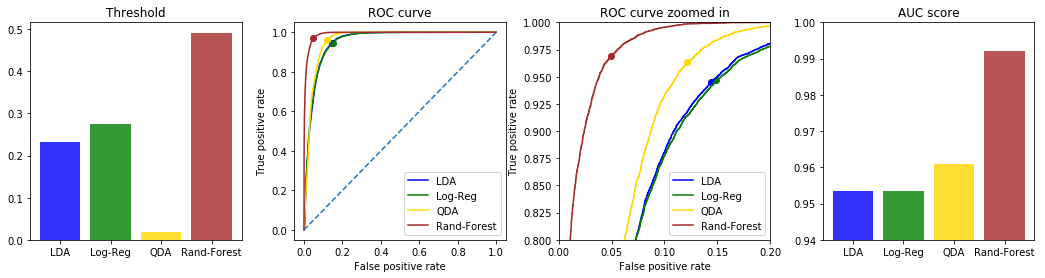

In [0]:
name_list = ["LDA","Log-Reg","QDA","Rand-Forest"]
color_list = ["blue","green","gold","brown"]
plt.figure(figsize=(18,4))


plt.subplot(141)
plt.bar(name_list,optimal_threshold_list, color=color_list, alpha = 0.8)
plt.title("Threshold")

plt.subplot(142)
for i in range(4):
  plt.plot(fpr_list[i],tpr_list[i],label=name_list[i], c=color_list[i])
  plt.scatter(fpr_list[i][optimal_idx_list[i]],tpr_list[i][optimal_idx_list[i]],marker='o', c=color_list[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], '--')

plt.subplot(143)
for i in range(4):
  plt.plot(fpr_list[i],tpr_list[i],label=name_list[i], c=color_list[i])
  plt.scatter(fpr_list[i][optimal_idx_list[i]],tpr_list[i][optimal_idx_list[i]],marker='o', c=color_list[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0.8,1.0)
plt.xlim(0,0.2)
plt.title('ROC curve zoomed in')
plt.legend(loc='best')

plt.subplot(144)
plt.bar(name_list,auc_list, color=color_list, alpha = 0.8)
plt.title("AUC score")
plt.ylim(0.94,1)

plt.subplots_adjust(wspace=0.25)

### Use split 2

In [0]:
FEATURE = ['NDAI',
 'SD',
 'CORR',
 'DF',
 'CF',
 'BF',
 'AF',
 'AN']

fpr_list = []
tpr_list = []
threshold_list = []
auc_list = []


#LDA
print("LDA")
model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
model.fit(train_2[FEATURE], train_2['label'])
score = model.predict_proba(test_2[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_2['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_2['label'], score[:,1])
fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)


# LR
print("LR")
model = sklearn.linear_model.LogisticRegression()
model.fit(train_2[FEATURE], train_2['label'])
score = model.predict_proba(test_2[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_2['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_2['label'], score[:,1])

fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)


# QDA
print("QDA")
model = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
model.fit(train_2[FEATURE], train_2['label'])
score = model.predict_proba(test_2[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_2['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_2['label'], score[:,1])

fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)


# SVM
# print("SVM")
# model = sklearn.svm.SVC(kernel = 'rbf',probability=True)
# model.fit(train_1[FEATURE], train_1['label'])
# score = model.predict_proba(test_1[FEATURE])
# fpr, tpr, threshold = sklearn.metrics.roc_curve(test_1['label'], score[:,1])
# auc = sklearn.metrics.roc_auc_score(test_1['label'], score[:,1])
# fpr_list.append(fpr)
# tpr_list.append(tpr)
# threshold_list.append(threshold)
# auc_list.append(auc)


print("RF")
# RF
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                                                  max_depth=20,
                                                  random_state=0)
model.fit(train_2[FEATURE], train_2['label'])
score = model.predict_proba(test_2[FEATURE])
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_2['label'], score[:,1])
auc = sklearn.metrics.roc_auc_score(test_2['label'], score[:,1])

fpr_list.append(fpr)
tpr_list.append(tpr)
threshold_list.append(threshold)
auc_list.append(auc)

LDA
LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


QDA
RF


In [0]:
optimal_threshold_list = []

for i in range(4):
  optimal_idx = np.argmax(tpr_list[i] - fpr_list[i])
  optimal_threshold = threshold_list[i][optimal_idx]
  optimal_threshold_list.append(optimal_threshold)

In [0]:
optimal_idx_list = []

for i in range(4):
  optimal_idx = np.argmax(tpr_list[i] - fpr_list[i])
  optimal_idx_list.append(optimal_idx)

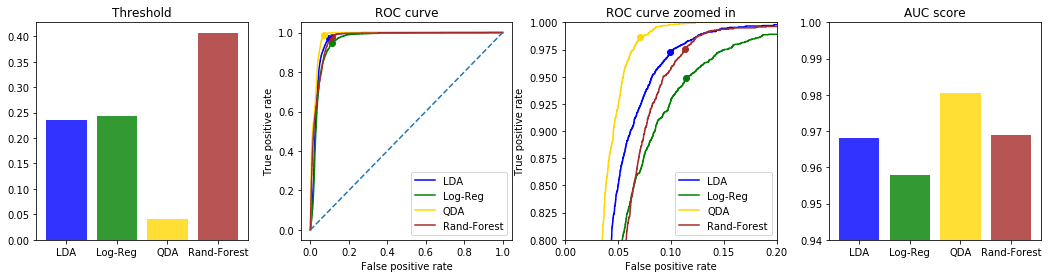

In [0]:
name_list = ["LDA","Log-Reg","QDA","Rand-Forest"]
color_list = ["blue","green","gold","brown"]
plt.figure(figsize=(18,4))


plt.subplot(141)
plt.bar(name_list,optimal_threshold_list, color=color_list, alpha = 0.8)
plt.title("Threshold")

plt.subplot(142)
for i in range(4):
  plt.plot(fpr_list[i],tpr_list[i],label=name_list[i], c=color_list[i])
  plt.scatter(fpr_list[i][optimal_idx_list[i]],tpr_list[i][optimal_idx_list[i]],marker='o', c=color_list[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], '--')

plt.subplot(143)
for i in range(4):
  plt.plot(fpr_list[i],tpr_list[i],label=name_list[i], c=color_list[i])
  plt.scatter(fpr_list[i][optimal_idx_list[i]],tpr_list[i][optimal_idx_list[i]],marker='o', c=color_list[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0.8,1.0)
plt.xlim(0,0.2)
plt.title('ROC curve zoomed in')
plt.legend(loc='best')

plt.subplot(144)
plt.bar(name_list,auc_list, color=color_list, alpha = 0.8)
plt.title("AUC score")
plt.ylim(0.94,1)


plt.subplots_adjust(wspace=0.25)


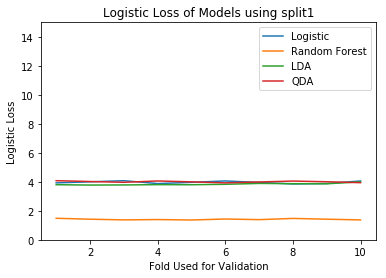

<Figure size 864x720 with 0 Axes>

In [0]:
k = np.arange(1, 11)
model_name = ['Logistic', 'Random Forest', 'LDA', 'QDA']
def plot_loss(models, method):
  plt.figure(1)
  for i in range(len(models)):
    plt.plot(k, models[i]['loss'], label = model_name[i])
  plt.xlabel('Fold Used for Validation')
  plt.ylabel('Logistic Loss')
  plt.title('Logistic Loss of Models using split' + str(method))
  plt.legend()
  plt.ylim((0, 15))
  plt.figure(figsize=(12,10))
  plt.show()
plot_loss([log_1, rf_1, LDA_1, QDA_1], '1')

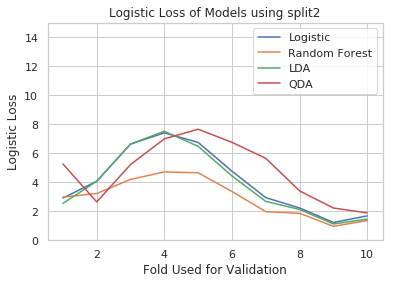

<Figure size 864x720 with 0 Axes>

In [0]:
plot_loss([log_2, rf_2, LDA_2, QDA_2], '2')

## 3. Other Metric

### 1. F1 Score

In [0]:
from sklearn.metrics import f1_score
def calculate_f1(models, train_feat, train_label, val_feat, val_label):
  f1_scores = []
  for model in models:
    model.fit(train_feat, train_label)
    y_score = model.predict(val_feat)
    f1_scores.append(f1_score(val_label, y_score, average='weighted'))
  return f1_scores

In [0]:
models = [
    sklearn.linear_model.LogisticRegression(),
    sklearn.ensemble.RandomForestClassifier(n_estimators=100,\
                                                  max_depth=20,\
                                                  random_state=0),\
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),\
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
]
f1_scores = calculate_f1(models, train_feat_1[FEATURE], train_label_1, val_all_feat, val_all_labels)
f1_scores += calculate_f1(models, train_feat_2[FEATURE], train_label_2, val_all_feat, val_all_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
split_method = np.repeat(1, 4)
split_method = np.append(split_method, np.repeat(2, 4))

In [0]:
model_name = np.array(['Logistic','Random Forest','LDA', 'QDA', \
                       'Logistic','Random Forest','LDA', 'QDA'])

Text(0.5, 0, 'Model')

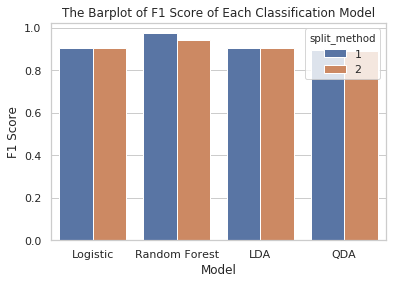

In [0]:
df = pd.DataFrame({'model': model_name,
                    'f1_score': f1_scores, 'split_method':split_method})
  
sns.set(style="whitegrid")
ax = sns.barplot(x="model", y="f1_score", hue = 'split_method', data=df)
ax.set_title('The Barplot of F1 Score of Each Classification Model')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Model')

### 2. Log Loss

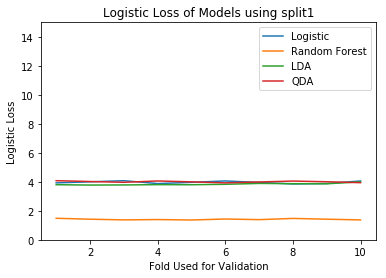

<Figure size 864x720 with 0 Axes>

In [0]:
k = np.arange(1, 11)
model_name = ['Logistic', 'Random Forest', 'LDA', 'QDA']
def plot_loss(models, method):
  plt.figure(1)
  for i in range(len(models)):
    plt.plot(k, models[i]['loss'], label = model_name[i])
  plt.xlabel('Fold Used for Validation')
  plt.ylabel('Logistic Loss')
  plt.title('Logistic Loss of Models using split' + str(method))
  plt.legend()
  plt.ylim((0, 15))
  plt.figure(figsize=(12,10))
  plt.show()
plot_loss([log_1, rf_1, LDA_1, QDA_1], '1')

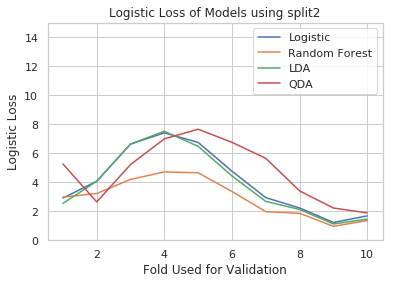

<Figure size 864x720 with 0 Axes>

In [0]:
plot_loss([log_2, rf_2, LDA_2, QDA_2], '2')

# Section 4. Diagnostics

## 1. Random Forest Parameter Tuning

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 120, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70, 110, num = 5)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(random_grid)

{'n_estimators': [100, 105, 110, 115, 120], 'max_depth': [70, 80, 90, 100, 110]}


In [0]:
rf = sklearn.ensemble.RandomForestClassifier()
grid_search = sklearn.model_selection.GridSearchCV(estimator = rf, param_grid = random_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(train_feat_2[FEATURE], train_label_2) # 15 70
#grid_search.fit(train_feat_1[FEATURE], train_label_1) # max_depth 30  n_estimators 70
grid_search.best_params_

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.7min finished


{'max_depth': 110, 'n_estimators': 110}

In [0]:
grid_search.cv_results_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([20.68824267, 22.70947409, 23.5458833 , 25.09538019, 26.25474644,
        21.83684516, 22.75390708, 23.84911954, 25.08038259, 26.19312453,
        21.5587039 , 22.89163411, 23.96440041, 25.11526287, 26.15402484,
        21.64344132, 22.75581253, 24.25251925, 25.34266293, 26.1565398 ,
        22.00421071, 22.93281555, 23.95665205, 24.96741724, 21.94881439]),
 'mean_score_time': array([1.6356498 , 1.73550558, 1.78344941, 1.91848409, 2.00134206,
        1.65386689, 1.70506918, 1.78765917, 1.95587623, 2.01877451,
        1.63300741, 1.76586199, 1.81929147, 1.97608709, 1.99416983,
        1.66978025, 1.7623781 , 1.83687067, 1.90978134, 1.99561155,
        1.67039084, 1.76871002, 1.81386089, 1.95664513, 1.75407815]),
 'mean_test_score': array([0.76499426, 0.76833467, 0.76880929, 0.76939807, 0.76719917,
        0.76567917, 0.76719316, 0.76926589, 0.76842478, 0.76935   ,
        0.76766178, 0.76901356, 0.76953625, 0.76537877, 0.76931396,
        0.76792613, 0.76971649, 

## 2. Misclassification Error

In [0]:
#Source:https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [0]:
from sklearn.model_selection import learning_curve
estimator = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 20)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

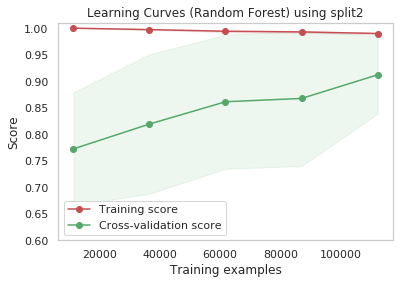

In [0]:
title_2 = r"Learning Curves (Random Forest) using split2"
X = train_feat_2[FEATURE]
y = train_label_2
plot_learning_curve(estimator, title_2, X, y, ylim=(0.6, 1.01), cv=10, n_jobs=-1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

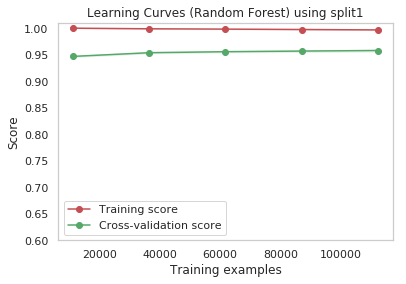

In [0]:
title_1 = r"Learning Curves (Random Forest) using split1"
X = train_feat_1[FEATURE]
y = train_label_1
plot_learning_curve(estimator, title_1, X, y, ylim=(0.6, 1.01), cv=10, n_jobs=-1)

# Section 5. Bancroft Model


In [0]:
img1_raw = pd.read_csv("./img1.csv", index_col=0)
img2_raw = pd.read_csv("./img2.csv", index_col=0)
img3_raw = pd.read_csv("./img3.csv", index_col=0)

In [0]:
col_names = ['x', 'y', 'label', 'NDAI', 'SD', 'CORR','DF','CF','BF','AF','AN']
img1_raw.columns = col_names
img2_raw.columns = col_names
img3_raw.columns = col_names

In [0]:
def get_neighbor_feature(curr_x, curr_y, low_x, high_x, low_y, high_y, img):
  next_corr, next_ndai, next_sd = 0.0, 0.0, 0.0
  count = 0
  for i in range(-1, 2, 1):
    for j in range(-1, 2, 1):
      if i == 0 and j == 0:
        continue
      next_x, next_y = curr_x + i, curr_y + j
      if next_x < low_x or next_x > high_x or next_y < low_y or next_y > high_y:
        continue
      neighbor_pixel = img[(img['x'] == next_x) & (img['y'] == next_y)]
      if not neighbor_pixel.empty:
        next_corr += neighbor_pixel.iloc[0]['CORR']
        next_ndai += neighbor_pixel.iloc[0]['NDAI']
        next_sd += neighbor_pixel.iloc[0]['SD']
        count += 1
  if count == 0:
    return (0,0,0)
  return (next_corr/count, next_ndai/count, next_sd/count)

In [0]:
def add_new_features(img):
  neighbor_corr, neighbor_ndai, neighbor_sd = [],[],[]
  low_x, high_x = min(img['x']), max(img['x'])
  low_y, high_y = min(img['y']), max(img['y'])
  
  for i in range(len(img)):
    curr_row = img.iloc[i]
    curr_x, curr_y = curr_row['x'], curr_row['y']
    if curr_row['label'] == 0:
      mean_corr, mean_ndai, mean_sd = (0,0,0)
    else:
      mean_corr, mean_ndai, mean_sd = get_neighbor_feature(curr_x, curr_y, \
                                                         low_x, high_x, \
                                                         low_y, high_y, \
                                                         img)
    neighbor_corr.append(mean_corr)
    neighbor_ndai.append(mean_ndai)
    neighbor_sd.append(mean_sd)
 
  img['Neighbor CORR'] = neighbor_corr
  img['Neighbor NDAI'] = neighbor_ndai
  img['Neighbor SD'] = neighbor_sd
  return img

In [0]:
img1_added = add_new_features(img1_raw)
img1_added = img1_added[img1_added['label'] != 0.0]

img2_added = add_new_features(img2_raw)
img2_added = img2_added[img2_added['label'] != 0.0]

img3_added = add_new_features(img3_raw)
img3_added = img3_added[img3_added['label'] != 0.0]

In [0]:
img1.shape[0]

70917

In [0]:
img2.shape[0]

82148

In [0]:
img3.shape[0]

54996

## Bancroft Model Analysis

In [0]:
img1_added['tag'] = 'img1' 
img2_added['tag'] = 'img2'
img3_added['tag'] = 'img3'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [0]:
data_combined = pd.concat([img1_added, img2_added])
data_combined = pd.concat([data_combined, img3_added])
data_combined.index = range(len(data_combined))
data_combined.to_csv('./data_combined.csv')

In [0]:
combined_train_1, combined_valid_1, combined_test_1 = split1(data_combined)

combined_train_1 = combined_train_1.sample(frac=1)
combined_test_1 = combined_test_1.sample(frac=1)
combined_valid_1 = combined_valid_1.sample(frac=1)

In [0]:
combined_train_2 = pd.concat([img1_added.iloc[:int(len(img1_added) * 0.6) , ],
                             img2_added.iloc[:int(len(img2_added) * 0.6) , ]])

combined_train_2 = pd.concat([combined_train_2, \
                              img3_added.iloc[:int(len(img3_added) * 0.6), ]])


combined_valid_2 = pd.concat([img1_added.iloc[int(len(img1_added)* 0.6):int(len(img1_added)* 0.8), ],
                             img2_added.iloc[int(len(img2_added)* 0.6):int(len(img2_added)* 0.8), ]])

combined_valid_2 = pd.concat([combined_valid_2, 
                              img3_added.iloc[int(len(img3_added)* 0.6):int(len(img3_added)* 0.8), ]])

combined_test_2 = pd.concat([img1_added.iloc[int(len(img1_added)* 0.8):, ],
                             img2_added.iloc[int(len(img2_added)* 0.8):, ]])
combined_test_2 = pd.concat([combined_test_2, \
                             img3_added.iloc[int(len(img3_added)* 0.8):, ]])

combined_train_2.to_csv('./combined_train_2.csv')
combined_valid_2.to_csv('./combined_valid_2.csv')
combined_test_2.to_csv('./combined_test_2.csv')


In [0]:
len(combined_test_2[combined_test_2['tag'] =='img3'])

11000

In [0]:
len(combined_valid_2[combined_valid_2['tag'] =='img3'])

10999

In [0]:
len(combined_train_2[combined_train_2['tag'] =='img3'])

32997

In [0]:
combined_valid_all = pd.concat([combined_valid_1, combined_valid_2])
combined_valid_all.drop_duplicates(subset = ['x', 'y', 'SD', 'NDAI','AF'], 
                     keep = 'first', inplace = True)

combined_test_all = pd.concat([combined_test_1, combined_test_2])
combined_test_all.drop_duplicates(subset = ['x', 'y', 'SD', 'NDAI','AF'], 
                     keep = 'first', inplace = True)

In [0]:
RANDOM_SEED = 2019
estimator_1 = sklearn.ensemble.RandomForestClassifier(n_estimators = 200, \
                                                      max_depth = 30, \
                                                      min_samples_split = 300,
                                                      max_features = 11, 
                                                     random_state = RANDOM_SEED)

estimator_2 = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, \
                                                      max_depth = 20, \
                                                      min_samples_split = 300,
                                                      max_features = 11,
                                                     random_state = RANDOM_SEED)

In [0]:
NEW_FEATURE = ['CORR','NDAI','SD','BF','DF', 'CF', 'AF','AN','Neighbor CORR',\
                'Neighbor NDAI','Neighbor SD']
estimator_1.fit(combined_train_1[NEW_FEATURE], combined_train_1['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=300,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False)

In [0]:
estimator_2.fit(combined_train_2[NEW_FEATURE], combined_train_2['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=300,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False)

In [0]:
pred_1 = estimator_1.predict(combined_valid_1[NEW_FEATURE])
print('Estimator 1 on valid_1: ' + str(np.mean(pred_1 == combined_valid_1['label'])))

pred_test_1 = estimator_1.predict(combined_test_1[NEW_FEATURE])
print('Estimator 1 on test_1: ' + str(np.mean(pred_test_1 == combined_test_1['label'])))

pred_valid_1 = estimator_1.predict(combined_valid_all[NEW_FEATURE])
print('Estimator 1 on valid_all: ' + str(np.mean(pred_valid_1 == combined_valid_all['label'])))
      
pred_test_1 = estimator_1.predict(combined_test_all[NEW_FEATURE])
print('Estimator 1 on test_all: ' + str(np.mean(pred_test_1 == combined_test_all['label'])))

Estimator 1 on valid_1: 0.9522253196193405
Estimator 1 on test_1: 0.9516016629418691
Estimator 1 on valid_all: 0.9622568457029946
Estimator 1 on test_all: 0.9633534404526771


In [0]:
pred_2 = estimator_2.predict(combined_valid_2[NEW_FEATURE])
print('Estimator 2 on valid_2: ' + str(np.mean(pred_2 == combined_valid_2['label'])))

pred_test_2 = estimator_2.predict(combined_test_2[NEW_FEATURE])
print('Estimator 2 on test_2: ' + str(np.mean(pred_test_2 == combined_test_2['label'])))

pred_valid_all_2 = estimator_2.predict(combined_valid_all[NEW_FEATURE])
print('Estimator 2 on valid_all: ' + str(np.mean(pred_valid_all_2 == combined_valid_all['label'])))
      
pred_test_all_2 = estimator_2.predict(combined_test_all[NEW_FEATURE])
print('Estimator 2 on test_all: ' + str(np.mean(pred_test_all_2 == combined_test_all['label'])))

Estimator 2 on valid_2: 0.9122128232240699
Estimator 2 on test_2: 0.9090690632960061
Estimator 2 on valid_all: 0.9242867251438566
Estimator 2 on test_all: 0.9216756525916832


In [0]:
importances = estimator_2.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [NEW_FEATURE[i] for i in indices])
plt.xlabel('Relative Importance')

## Experiment

### Run Train1 on new feature

In [0]:
comb_model_1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=20,
                                                    max_features=11, random_state=RANDOM_SEED,
                                                    min_samples_split = 300)
comb_model_1.fit(comb_train_1[FEATURE],comb_train_1["label"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=300,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False)

In [0]:
# Predict Validation
comb_val_hat = comb_model_1.predict(combined_valid_all[FEATURE])
print(np.mean(comb_val_hat == combined_valid_all['label']))
comb_false_classified = combined_valid_all[comb_val_hat != combined_valid_all['label']]
comb_correct_classified = combined_valid_all[comb_val_hat == combined_valid_all['label']]

0.9560359685275384


In [0]:
# Predict test_all
comb_test_hat = comb_model_1.predict(combined_test_all[FEATURE])
print(np.mean(comb_test_hat == combined_test_all['label']))
comb_false_classified = combined_test_all[comb_test_hat != combined_test_all['label']]
comb_correct_classified = combined_test_all[comb_test_hat == combined_test_all['label']]

0.9567406763531183


In [0]:
# Predict test_1
comb_test_hat = comb_model_1.predict(comb_test_1[FEATURE])
print(np.mean(comb_test_hat == comb_test_1['label']))
comb_false_classified = comb_test_1[comb_test_hat != comb_test_1['label']]
comb_correct_classified = comb_test_1[comb_test_hat == comb_test_1['label']]

0.9525629010165093


In [0]:
# Predict all pixels
comb_all_hat = comb_model_1.predict(data_combined[FEATURE])
print(np.mean(comb_all_hat == data_combined['label']))
comb_false_classified = data_combined[comb_all_hat != data_combined['label']]
comb_correct_classified = data_combined[comb_all_hat == data_combined['label']]

0.953729915745863


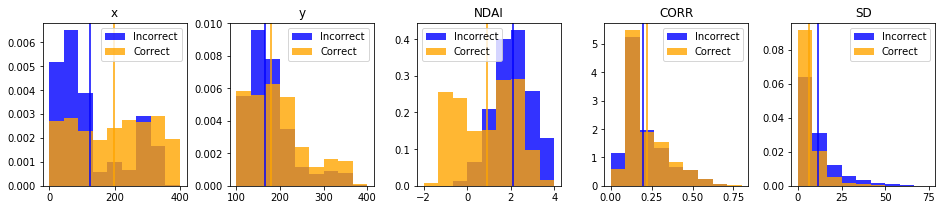

In [0]:
bins = [np.linspace(0,400,10),
        np.linspace(100,400,10),
        np.linspace(-2,4,10),
       np.linspace(0,0.8,10),
       np.linspace(0,75,10)]

plt.figure(figsize=(16,3))

for i,name in enumerate(['x','y','NDAI','CORR','SD']):
  plt.subplot(1,5,1+i)
  plt.hist(comb_false_classified[name],bins[i], density = True, label = "Incorrect", alpha = 0.8, color='blue')
  plt.hist(comb_correct_classified[name], bins[i], density = True, label="Correct", alpha = 0.8, color='orange')
  plt.legend()
  plt.axvline(x=np.mean(comb_false_classified[name]),c='blue')
  plt.axvline(x=np.mean(comb_correct_classified[name]),c='orange')
  plt.title(name)
plt.subplots_adjust(wspace=0.3)

In [0]:
comb_img1_misclassified = comb_false_classified[comb_false_classified['tag'] == 'img1']
comb_img2_misclassified = comb_false_classified[comb_false_classified['tag'] == 'img2']
comb_img3_misclassified = comb_false_classified[comb_false_classified['tag'] == 'img3']

Text(0.5, 1.0, 'Image 3')

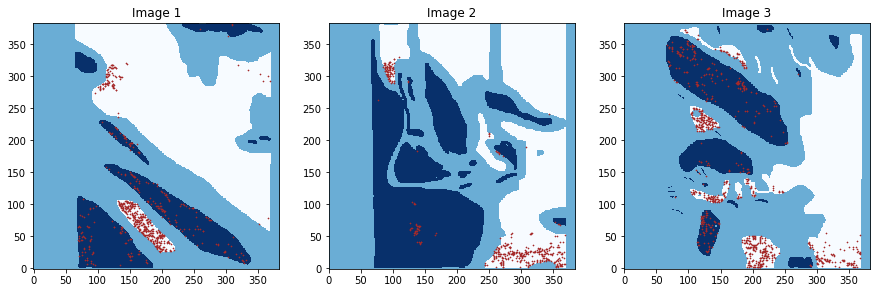

In [0]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img1_pad,cmap="Blues", origin='lower')
plt.scatter(comb_img1_misclassified['y'],comb_img1_misclassified['x'],c='brown',marker='x',s=0.5)
plt.title("Image 1")

plt.subplot(1,3,2)
plt.imshow(img2_pad,cmap="Blues",origin='lower')
plt.scatter(comb_img2_misclassified['y'],comb_img2_misclassified['x'],c='brown',marker='x', s=0.5)
plt.title("Image 2")

plt.subplot(1,3,3)
plt.imshow(img3_pad,cmap="Blues",origin='lower')
plt.scatter(comb_img3_misclassified['y'], comb_img3_misclassified['x'],c='brown',marker='x', s=0.5)
plt.title("Image 3")

Text(0.5, 0, 'Relative Importance')

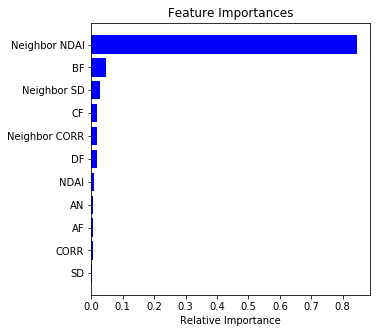

In [0]:
importances = comb_model_1.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [FEATURE[i] for i in indices])
plt.xlabel('Relative Importance')

### Run train 2 on new feature

In [0]:
FEATURE

['NDAI',
 'SD',
 'CORR',
 'DF',
 'CF',
 'BF',
 'AF',
 'AN',
 'Neighbor CORR',
 'Neighbor NDAI',
 'Neighbor SD']

In [0]:
comb_model_2 = sklearn.ensemble.RandomForestClassifier(n_estimators=50, max_depth=10,
                                                    max_features=11, random_state=2019,
                                                    min_samples_split = 300)
comb_model_2.fit(combined_train_2[FEATURE], combined_train_2["label"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=300,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False)

In [0]:
# Predict Validation
comb_val_hat = comb_model_2.predict(combined_valid_all[FEATURE])
print(np.mean(comb_val_hat == combined_valid_all['label']))
comb_false_classified = combined_valid_all[comb_val_hat != combined_valid_all['label']]
comb_correct_classified = combined_valid_all[comb_val_hat == combined_valid_all['label']]

0.9211939102564103


In [0]:
# # Predict Validation
# comb_val_hat = comb_model_2.predict(combined_valid_2[FEATURE])
# print(np.mean(comb_val_hat == combined_valid_2['label']))
# comb_false_classified = combined_valid_2[comb_val_hat != combined_valid_2['label']]
# comb_correct_classified = combined_valid_2[comb_val_hat == combined_valid_2['label']]

0.9745203704521695


In [0]:
# # Predict test
# comb_test_hat = comb_model_2.predict(combined_test_all[FEATURE])
# print(np.mean(comb_test_hat == combined_test_all['label']))
# comb_false_classified = combined_test_all[comb_test_hat != combined_test_all['label']]
# comb_correct_classified = combined_test_all[comb_test_hat == combined_test_all['label']]

0.9189140583435118


In [0]:
# # Predict all pixels
# comb_all_hat = comb_model_2.predict(data_combined[FEATURE])
# print(np.mean(comb_all_hat == data_combined['label']))
# comb_false_classified = data_combined[comb_all_hat != data_combined['label']]
# comb_correct_classified = data_combined[comb_all_hat == data_combined['label']]

0.8091905739182259


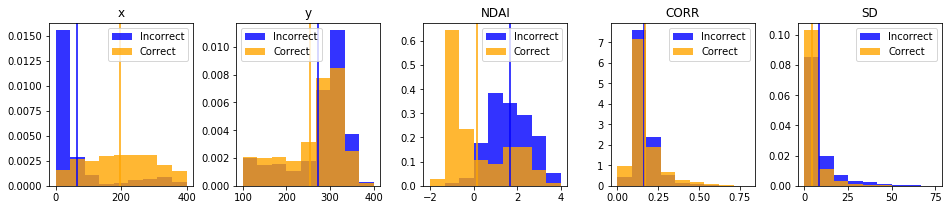

In [0]:
bins = [np.linspace(0,400,10),
        np.linspace(100,400,10),
        np.linspace(-2,4,10),
       np.linspace(0,0.8,10),
       np.linspace(0,75,10)]

plt.figure(figsize=(16,3))

for i,name in enumerate(['x','y','NDAI','CORR','SD']):
  plt.subplot(1,5,1+i)
  plt.hist(comb_false_classified[name],bins[i], density = True, label = "Incorrect", alpha = 0.8, color='blue')
  plt.hist(comb_correct_classified[name], bins[i], density = True, label="Correct", alpha = 0.8, color='orange')
  plt.legend()
  plt.axvline(x=np.mean(comb_false_classified[name]),c='blue')
  plt.axvline(x=np.mean(comb_correct_classified[name]),c='orange')
  plt.title(name)
plt.subplots_adjust(wspace=0.3)

In [0]:
comb_img1_misclassified = comb_false_classified[comb_false_classified['tag'] == 'img1']
comb_img2_misclassified = comb_false_classified[comb_false_classified['tag'] == 'img2']
comb_img3_misclassified = comb_false_classified[comb_false_classified['tag'] == 'img3']

Text(0.5, 1.0, 'Image 3')

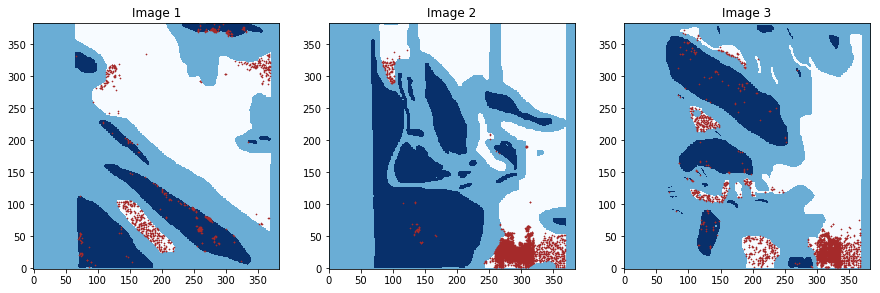

In [0]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img1_pad,cmap="Blues", origin='lower')
plt.scatter(comb_img1_misclassified['y'],comb_img1_misclassified['x'],c='brown',marker='x',s=0.5)
plt.title("Image 1")

plt.subplot(1,3,2)
plt.imshow(img2_pad,cmap="Blues",origin='lower')
plt.scatter(comb_img2_misclassified['y'],comb_img2_misclassified['x'],c='brown',marker='x', s=0.5)
plt.title("Image 2")

plt.subplot(1,3,3)
plt.imshow(img3_pad,cmap="Blues",origin='lower')
plt.scatter(comb_img3_misclassified['y'], comb_img3_misclassified['x'],c='brown',marker='x', s=0.5)
plt.title("Image 3")

Text(0.5, 0, 'Relative Importance')

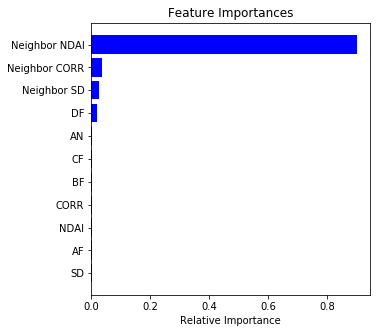

In [0]:
importances = comb_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [FEATURE[i] for i in indices])
plt.xlabel('Relative Importance')

# Appendix

## A. Create Padding for `plt.imshow`

Padding for NDAI

In [0]:
# Create Padding for imshow()

img3_pad_ndai = np.zeros((384,384))
for i in img3.index:
  img3_pad_ndai[int(img3.loc[i]['x']),int(img3.loc[i]['y'])] = img3.loc[i]['NDAI']

img2_pad_ndai = np.zeros((384,384))
for i in img2.index:
  img2_pad_ndai[int(img2.loc[i]['x']),int(img2.loc[i]['y'])] = img2.loc[i]['NDAI']

img1_pad_ndai = np.zeros((384,384))
for i in img1.index:
  img1_pad_ndai[int(img1.loc[i]['x']),int(img1.loc[i]['y'])] = img1.loc[i]['NDAI']

In [0]:
np.save("./img1_pad_ndai.npy",img1_pad_ndai)
np.save("./img2_pad_ndai.npy",img2_pad_ndai)
np.save("./img3_pad_ndai.npy",img3_pad_ndai)

Padding for SD

In [0]:
# Create Padding for imshow()

img3_pad_sd = np.zeros((384,384))
for i in img3.index:
  img3_pad_sd[int(img3.loc[i]['x']),int(img3.loc[i]['y'])] = img3.loc[i]['SD']

img2_pad_sd = np.zeros((384,384))
for i in img2.index:
  img2_pad_sd[int(img2.loc[i]['x']),int(img2.loc[i]['y'])] = img2.loc[i]['SD']

img1_pad_sd = np.zeros((384,384))
for i in img1.index:
  img1_pad_sd[int(img1.loc[i]['x']),int(img1.loc[i]['y'])] = img1.loc[i]['SD']

In [0]:
np.save("./img1_pad_sd.npy",img1_pad_sd)
np.save("./img2_pad_sd.npy",img2_pad_sd)
np.save("./img3_pad_sd.npy",img3_pad_sd)

 corr Filter

In [0]:
# Create Padding for imshow()

img3_pad_corr = np.zeros((384,384))
for i in img3.index:
  img3_pad_corr[int(img3.loc[i]['x']),int(img3.loc[i]['y'])] = img3.loc[i]['CORR']

img2_pad_corr = np.zeros((384,384))
for i in img2.index:
  img2_pad_corr[int(img2.loc[i]['x']),int(img2.loc[i]['y'])] = img2.loc[i]['CORR']

img1_pad_corr = np.zeros((384,384))
for i in img1.index:
  img1_pad_corr[int(img1.loc[i]['x']),int(img1.loc[i]['y'])] = img1.loc[i]['CORR']

In [0]:
np.save("./img1_pad_corr.npy",img1_pad_corr)
np.save("./img2_pad_corr.npy",img2_pad_corr)
np.save("./img3_pad_corr.npy",img3_pad_corr)